<a href="https://colab.research.google.com/github/aishwarya4699/Mood2Music_SpotifyRecommender/blob/main/Spotify_Mood_based_Recommender_(RAG_%2B_NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn transformers
!pip install unidecode
!pip install textblob
!pip install --upgrade pip
!pip install --upgrade torch transformers
!pip install transformers
# Install torch with CUDA 11.8 compatible build (works for Colab GPU)
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install sentence-transformers

  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x8

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Phase 1: Data Loading & Cleaning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
file_path = '/content/songs_with_attributes_and_lyrics.csv'

df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')
print(df.shape)
df.head()

(5375, 17)


,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500,"He said he came from Jamaica,\n he owned a cou..."
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000,"Fucked a bitch, now she running with my kids\n..."
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413,"Oh, my God, I'm going crazy\n"
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173,Continuamente se extraÃ±a la gente si no puede...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827,Continuamente se extraÃ±a la gente si no puede...


# Phase 2: Exploratory Data Analysis (EDA)

In [6]:
# Basic Info
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

# Data Types and Nulls
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Shape: (5375, 17)

Columns:
 Index(['id', 'name', 'album_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'lyrics'],
      dtype='object')

Data Types:
 id                   object
name                 object
album_name           object
artists              object
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
lyrics               object
dtype: object

Missing Values:
 id                     0
name                   0
album_name          3167
artists                0
danceability           0
energy                 0
key                    0
loudness               0
mode 

In [7]:
# Drop rows with missing lyrics as they are critical for NLP
df = df.dropna(subset=['lyrics'])
print("Shape after dropping missing lyrics:", df.shape)

Shape after dropping missing lyrics: (5375, 17)


In [8]:
# Summary of numerical columns
print(df.describe())

       danceability       energy     loudness  speechiness  acousticness  \
count   5375.000000  5375.000000  5375.000000  5375.000000   5375.000000   
mean       0.553417     0.643333    -8.124754     0.099447      0.294055   
std        0.173149     0.244195     4.001465     0.120147      0.319276   
min        0.000000     0.000020   -33.265000     0.000000      0.000001   
25%        0.431500     0.464500   -10.174000     0.035100      0.014150   
50%        0.562000     0.682000    -7.300000     0.051100      0.151000   
75%        0.682000     0.854000    -5.234000     0.107000      0.548500   
max        0.968000     1.000000    -0.251000     0.956000      0.996000   

       instrumentalness     liveness      valence        tempo   duration_ms  
count       5375.000000  5375.000000  5375.000000  5375.000000  5.375000e+03  
mean           0.072452     0.224950     0.498594   122.100639  2.219954e+05  
std            0.200082     0.197717     0.248418    29.713315  1.021092e+05  

**Summary**

* Danceability: avg 0.55 (moderate), range 0–0.98
* Energy: avg 0.66 (high), range 0–1
* Loudness: median -7 dB
* Speechiness: median 0.05 (mostly musical)
* Acousticness: median 0.14 (few acoustic tracks)
* Instrumentalness: very low (most tracks have vocals)
* Valence: avg 0.48 (neutral mood)
* Tempo: median 120 BPM (standard pop tempo)
* Duration: avg ~3.9 mins; max ~79 mins (some outliers)
* Missing: ‘album_name’ (58k), ‘lyrics’ (dropped 5 rows)

## Data Visualizations

### 1. Loudness vs Energy

[Text(0.5, 1.0, 'Loudness vs Energy')]

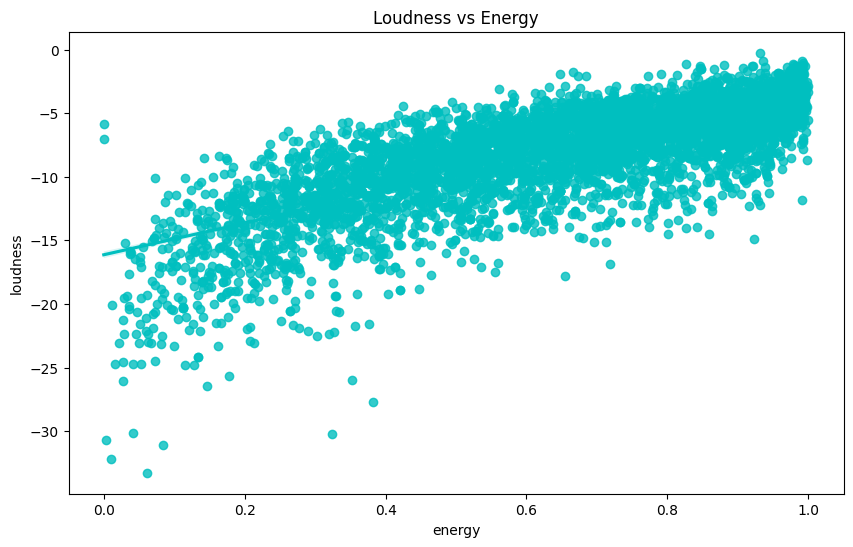

In [9]:
plt.figure(figsize=(10,6))
sns.regplot(data = df, y= "loudness", x = "energy", color = "c").set(title="Loudness vs Energy")

 Insight - Positive correlation between a track’s energy and its loudness, so higher energy songs tend to be louder.

### 2. Correlation Heatmap
It shows which song attributes move together, to build smarter queries and avoid redundant features in RAG or recommendation models

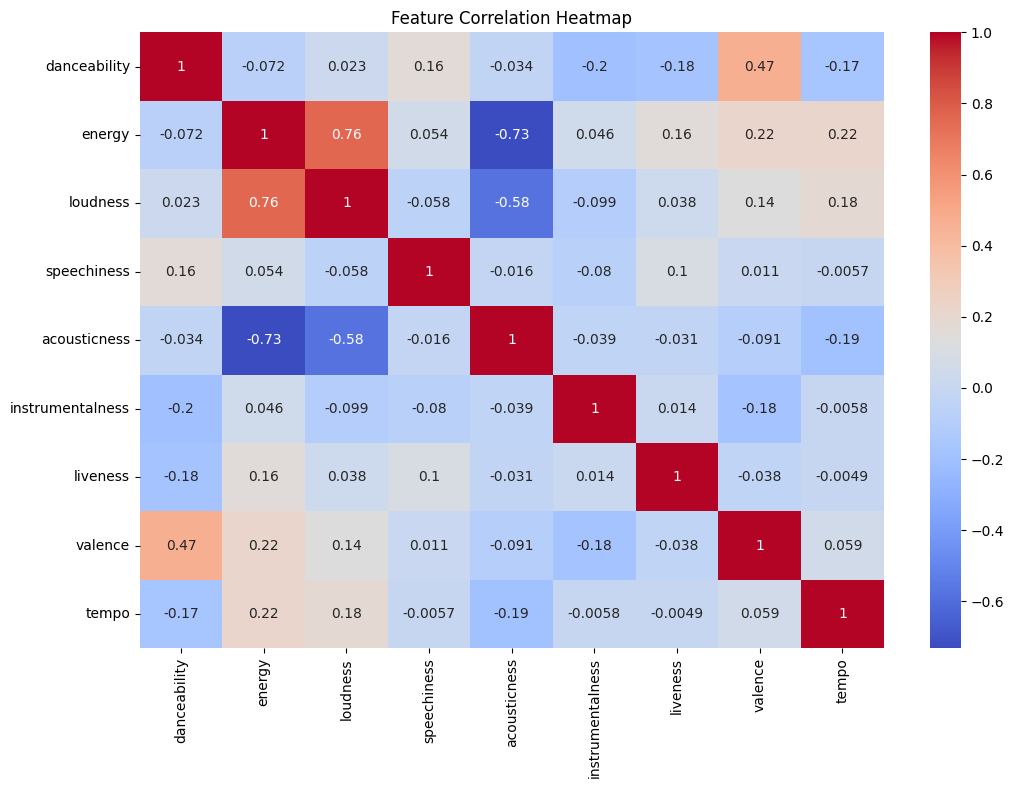

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(df[['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

Insights
* Energy and loudness are highly positively correlated (0.77)
* Energy and acousticness are highly negatively correlated (-0.72)

Helps end goal by:
* Designing better retrieval queries (e.g. energetic & acoustic are opposites).
* Feature selection for recommendations or RAG embeddings.

### 3. Danceability vs Valence Scatter Plot

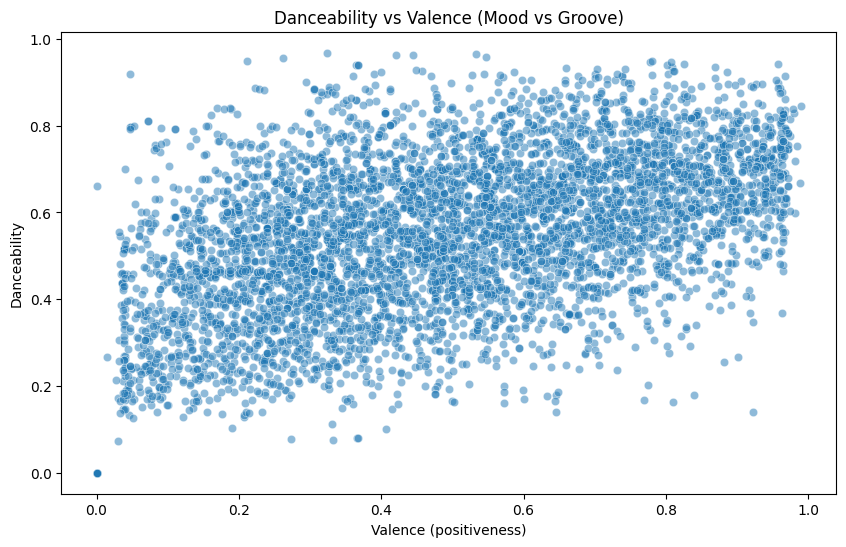

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='valence', y='danceability', alpha=0.5)
plt.title('Danceability vs Valence (Mood vs Groove)')
plt.xlabel('Valence (positiveness)')
plt.ylabel('Danceability')
plt.show()

Insight - Danceability increases slightly with valence, so happier songs is more danceable.

### 4. Top Artists Bar Plot

/tmp/ipython-input-12-1388537596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')


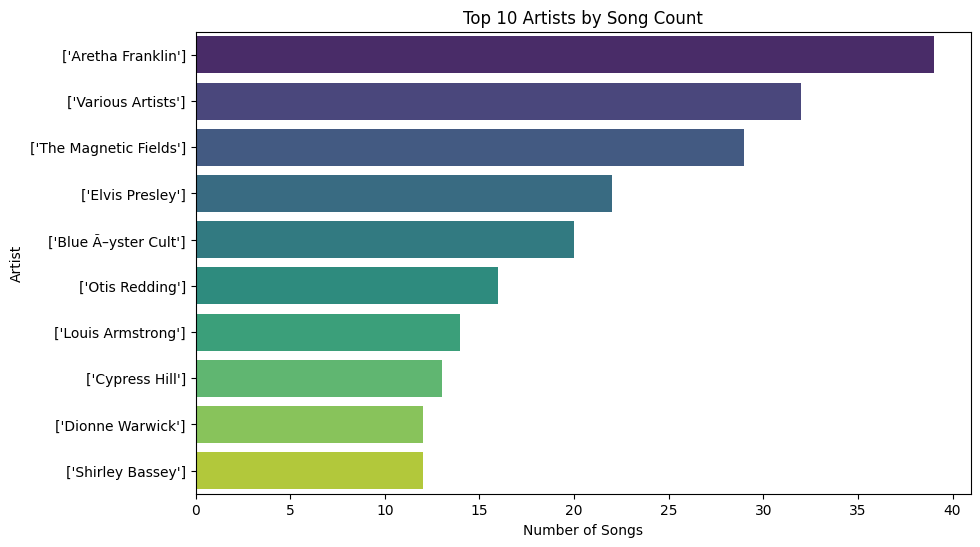

In [12]:
plt.figure(figsize=(10,6))
top_artists = df['artists'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Artists by Song Count')
plt.xlabel('Number of Songs')
plt.ylabel('Artist')
plt.show()

### 5. Distribution of Valence

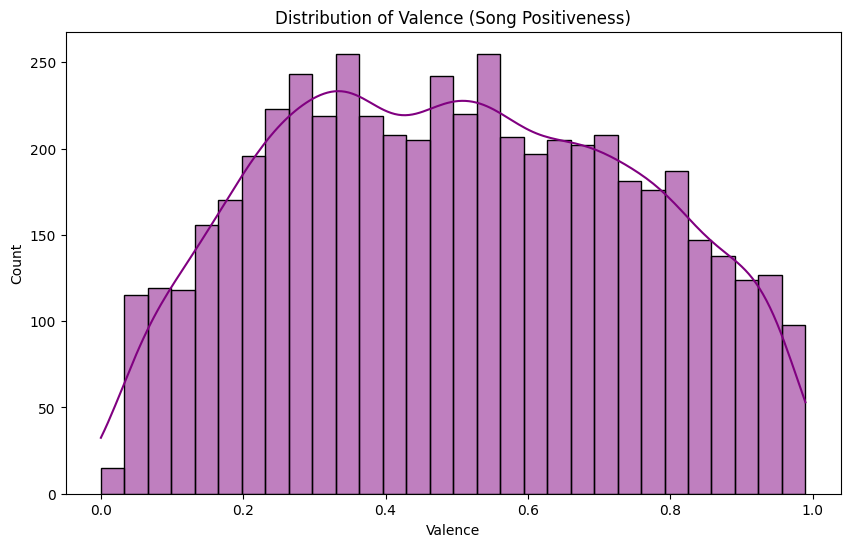

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(df['valence'], bins=30, kde=True, color='purple')
plt.title('Distribution of Valence (Song Positiveness)')
plt.xlabel('Valence')
plt.ylabel('Count')
plt.show()

Insight - Valence distribution is almost uniform - diverse emotional content in songs.

## Word Cloud

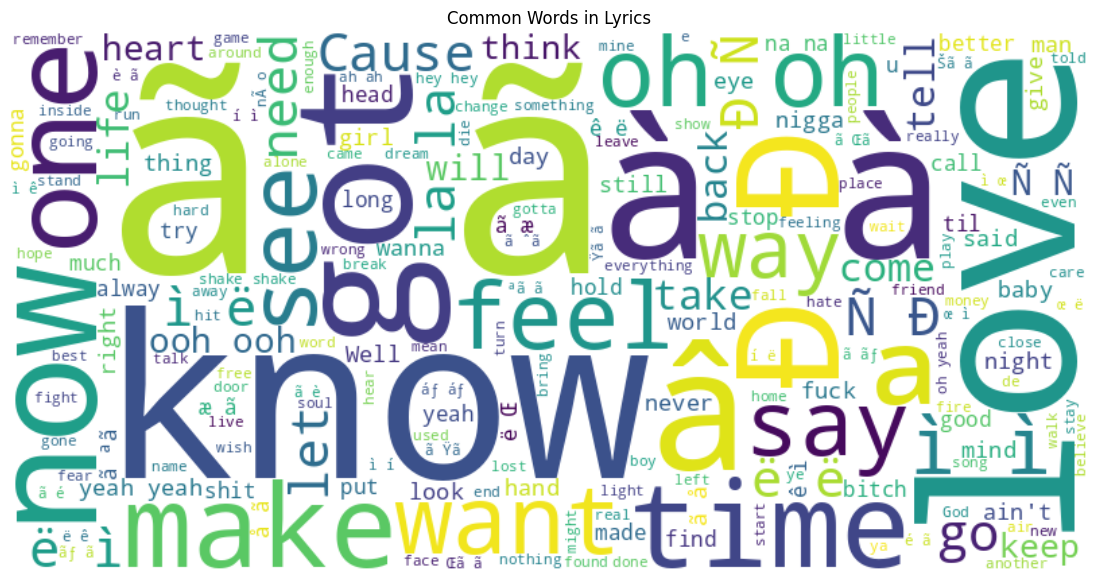

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Join all lyrics into one string
text = " ".join(lyrics for lyrics in df['lyrics'].astype(str))

# Create word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=200, width=800, height=400).generate(text)

# Plot
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Lyrics')
plt.show()

Insight - This word cloud shows the most frequent words in song lyrics with common word like love, knowing, wanting and time.

Some encoding symbols (e.g. 'à', '¾') are present, so I need to do text cleaning before NLP or RAG-based modeling to ensure clean, meaningful embeddings.

# Phase 3: Data Cleaning for Lyrics

In [15]:
import re
import unidecode

def clean_lyrics(text):
    text = unidecode.unidecode(text)  # normalize accents
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Apply to dataset
df['clean_lyrics'] = df['lyrics'].apply(clean_lyrics)

# Preview cleaned lyrics
df[['lyrics', 'clean_lyrics']].head()

,lyrics,clean_lyrics
0,"He said he came from Jamaica,\n he owned a cou...",he said he came from jamaica he owned a couple...
1,"Fucked a bitch, now she running with my kids\n...",fucked a bitch now she running with my kids an...
2,"Oh, my God, I'm going crazy\n",oh my god im going crazy
3,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...
4,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...


In [16]:
# Save as CSV for easy reload later
df.to_csv('spotify_cleaned_with_textblob.csv', index=False)

# Phase 4: Sentiment Analysis

Goal: Sentiment insights for mood-based retrieval or recommendations

## 4.1 Using TextBlob

* Fast lexicon-based sentiment analysis
* Generates polarity scores between -1 (negative) to +1 (positive)

In [17]:
import pandas as pd

# Load saved dataset instead of re-running cleaning + textblob
df = pd.read_csv('spotify_cleaned_with_textblob.csv')

print(df.shape)
df.head()

(5375, 18)


,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,clean_lyrics
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500,"He said he came from Jamaica,\n he owned a cou...",he said he came from jamaica he owned a couple...
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000,"Fucked a bitch, now she running with my kids\n...",fucked a bitch now she running with my kids an...
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413,"Oh, my God, I'm going crazy\n",oh my god im going crazy
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...


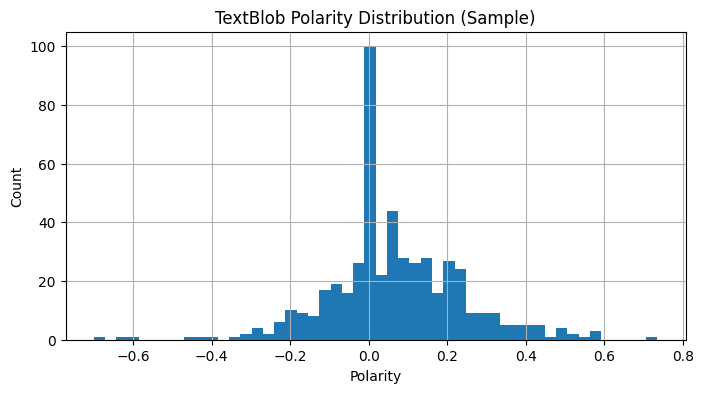

In [18]:
sample_df = df.sample(500, random_state=42).copy()

from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

sample_df['sentiment_polarity'] = sample_df['clean_lyrics'].apply(get_sentiment)

# Quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sample_df['sentiment_polarity'].hist(bins=50)
plt.title('TextBlob Polarity Distribution (Sample)')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

Insight - Most lyrics have polarity near zero, so a neutral sentiment with a slight skew towards positive emotions.

## 4.2 Using Hugging Face Transformer (Sample)

In [19]:
from transformers import pipeline

# Initialize sentiment pipeline (default: distilbert sentiment classifier)
sentiment_pipeline = pipeline("sentiment-analysis")

# Test on a single sample first (ALWAYS test before batch processing)
print(sentiment_pipeline("I love this song so much"))

# Apply on a smaller sample to avoid RAM crash
sample_df = df.sample(100, random_state=42).copy()  # sample 100 rows for demo

# Apply transformer sentiment analysis safely (limit input to 512 tokens)
sample_df['transformer_sentiment'] = sample_df['clean_lyrics'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

# View results
sample_df[['clean_lyrics', 'transformer_sentiment']].head()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[{'label': 'POSITIVE', 'score': 0.9998782873153687}]


,clean_lyrics,transformer_sentiment
410,well i might get uptight and never find the ri...,NEGATIVE
5294,ma pa hin tolmu plaadiriiulilt on vana pleier ...,NEGATIVE
2803,oh baby baby oh baby baby oh baby baby how was...,NEGATIVE
3957,oh oh tell me where you got this from why beca...,NEGATIVE
4577,we dont even know how to play the kettle drum ...,NEGATIVE


In [20]:
import re

# Function to detect gibberish or overly short/meaningless lyrics
def is_gibberish(text):
    # Remove spaces and check if >70% is non-alphabetic or too short
    cleaned = re.sub(r'\s+', '', text)
    non_alpha_ratio = sum(1 for c in cleaned if not c.isalpha()) / len(cleaned) if len(cleaned) > 0 else 1
    return (non_alpha_ratio > 0.5) or (len(cleaned) < 10)

# Apply and filter
df = df[~df['clean_lyrics'].apply(is_gibberish)]

print(df.shape)

(5375, 18)


In [21]:
df.to_csv('spotify_cleaned_with_sentiment.csv', index=False)

# Phase 5

In [22]:
import pandas as pd
df = pd.read_csv('spotify_cleaned_with_sentiment.csv')
df.head()

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,clean_lyrics
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500,"He said he came from Jamaica,\n he owned a cou...",he said he came from jamaica he owned a couple...
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000,"Fucked a bitch, now she running with my kids\n...",fucked a bitch now she running with my kids an...
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413,"Oh, my God, I'm going crazy\n",oh my god im going crazy
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827,Continuamente se extraÃ±a la gente si no puede...,continuamente se extraaa la gente si no puede ...


## Import and Load Model

In [23]:
from sentence_transformers import SentenceTransformer

# Load a lightweight powerful model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Generate Embeddings

In [24]:
import torch

In [25]:
# Sample 3000 rows from your cleaned dataframe
df_sample = df.sample(n=3000, random_state=42).reset_index(drop=True)

print(df_sample.shape)
df_sample.head()

(3000, 18)


,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics,clean_lyrics
0,3koAwrM1RO0TGMeQJ3qt9J,$10,Prize//Reward,Good Morning,0.624,0.596,4,-9.804,1,0.0314,0.4750,0.20300,0.1190,0.896,120.969,89508,"Well, I might get uptight\n And never find the...",well i might get uptight and never find the ri...
1,72fzKOFfMOCSXen9X4mjA6,1987,Moonwalk Street (Deluxe Version) - 77 Estonian...,['Mari-Leen'],0.694,0.948,7,-3.132,1,0.0638,0.0182,0.00358,0.0799,0.761,118.010,183304,Ma pÃ¼hin tolmu plaadiriiulilt\n On vana pleie...,ma pa hin tolmu plaadiriiulilt on vana pleier ...
2,1Zqs6A90va6FUxQ7KJAckG,...baby one more time,...baby one more time,['The MarÃ­as'],0.706,0.169,0,-15.428,0,0.0487,0.6440,0.02210,0.1100,0.678,179.999,125333,"Oh baby, baby\n Oh baby, baby\n \n Oh baby, ba...",oh baby baby oh baby baby oh baby baby how was...
3,4oEA3a7mE5bWNPi6ky4fcU,100000 - Unfinished,Leak 04-13 (Bait Ones),['Jai Paul'],0.531,0.665,10,-5.743,1,0.1620,0.3030,0.00000,0.1870,0.636,62.375,175267,Oh\n Oh\n Tell me where you got this from\n Wh...,oh oh tell me where you got this from why beca...
4,3NMpTQmnPsg4sTWtHHTUUn,14 Time,NaN,Popes Of Chillitown,0.685,0.831,11,-5.877,1,0.0871,0.1660,0.00000,0.1030,0.795,98.375,219907,We don't even know how to play the kettle drum...,we dont even know how to play the kettle drum ...


In [26]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Convert lyrics to list
lyrics_list = df_sample['clean_lyrics'].tolist()

# Encode in batches efficiently
embeddings = model.encode(lyrics_list, batch_size=32, show_progress_bar=True, device=device)

# Convert to numpy array
embeddings = np.array(embeddings)

print("Embeddings shape:", embeddings.shape)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings shape: (3000, 384)


In [27]:
# Attach embeddings to your sample dataframe
df_sample['embedding'] = embeddings.tolist()

# Save for Phase 6 RAG retrieval
df_sample.to_csv('spotify_sample_with_embeddings.csv', index=False)
np.save('lyrics_sample_embeddings.npy', embeddings)

# Phase 6: Retrieval & QA Pipeline

6.1 Load embeddings and data

In [28]:
import pandas as pd
import numpy as np

# Load
df_sample = pd.read_csv('spotify_sample_with_embeddings.csv')
embeddings = np.load('lyrics_sample_embeddings.npy')

print(df_sample.shape, embeddings.shape)

(3000, 19) (3000, 384)


6.2 Define retrieval function using cosine similarity

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve(query, model, df, embeddings, top_k=5):
    # Encode query
    query_emb = model.encode([query])

    # Calculate cosine similarity
    sims = cosine_similarity(query_emb, embeddings)[0]

    # Get top_k indices
    top_k_idx = sims.argsort()[-top_k:][::-1]

    # Return results
    return df.iloc[top_k_idx][['name', 'artists', 'clean_lyrics']]

6.3 Test retrieval

In [30]:
# Query
results = retrieve("I want a sad song", model, df_sample, embeddings, top_k=3)

print(results)

                                                   name  \
1475  (Hey Won't You Play) Another Somebody Done Som...   
1574                  11 O'Clock Tick Tock - Remastered   
1315                    (My My) Baby's Gonna Cry - Live   

                                             artists  \
1475                                 ['B.J. Thomas']   
1574                                          ['U2']   
1315  ['Eurythmics', 'Annie Lennox', 'Dave Stewart']   

                                           clean_lyrics  
1475  its lonely out tonight and the feelin just got...  
1574  its cold outside it gets so hot in here and th...  
1315  do you feel sorry lover do you feel blue what ...  


In [31]:
import pandas as pd

pd.set_option('display.max_colwidth', None)  # show full text in cells
pd.set_option('display.max_rows', None)      # show all rows

# Display results again
print(results)

                                                                name  \
1475  (Hey Won't You Play) Another Somebody Done Somebody Wrong Song   
1574                               11 O'Clock Tick Tock - Remastered   
1315                                 (My My) Baby's Gonna Cry - Live   

                                             artists  \
1475                                 ['B.J. Thomas']   
1574                                          ['U2']   
1315  ['Eurythmics', 'Annie Lennox', 'Dave Stewart']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      